# Problem Set 2

In [53]:
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import shapiro, bartlett
from matplotlib import pyplot as plt
import pandas

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf

In [3]:
def set_fontsize(ax,fsz):
    """
    Set the fontsize throughout an Axis
    
    Args:
        ax (Matplotlib Axis): 
        fsz (float): Font size

    Returns:

    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)


# Question 1

## Load

In [6]:
ps2_data = pandas.read_table('PS2_data-3.txt', delim_whitespace=True)#,skiprows=5,
                       #names=['year', 'SST', 'eSST'])
ps2_data.head()

,year,month,dd,y
0,2011,1,2011.08,0.28
1,2011,2,2011.15,0.40
2,2011,3,2011.23,0.43
3,2011,4,2011.31,0.40
4,2011,5,2011.38,0.32


## Date

In [7]:
dates = []
for index, row in ps2_data.iterrows():
    dates.append(f'{int(row.year)}-{int(row.month)}')
dates = pandas.to_datetime(dates)
ps2_data['date'] = dates
ps2_data.set_index('date', inplace=True)
ps2_data.head()

,year,month,dd,y
date,,,,
2011-01-01,2011,1,2011.08,0.28
2011-02-01,2011,2,2011.15,0.40
2011-03-01,2011,3,2011.23,0.43
2011-04-01,2011,4,2011.31,0.40
2011-05-01,2011,5,2011.38,0.32


## Plot

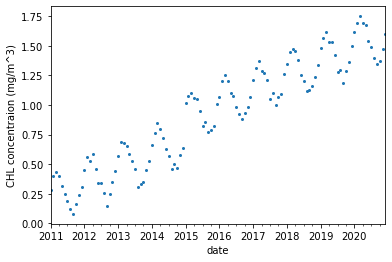

In [13]:
ps2_data.y.plot(ylabel='CHL concentraion (mg/m^3)', marker='o', ms=2., ls='')
plt.savefig('PS2_Q1_CHL.png', dpi=300)

----

# Question 2 -- Linear trend + Seasonal

## Dummy variables

In [14]:
dummy = np.zeros((len(ps2_data), 11), dtype=int)
for i in np.arange(11):
    for j in np.arange(len(ps2_data)):
        if ps2_data.month.values[j] == i+1:
            dummy[j,i] = 1

## Data frame

In [16]:
time = np.arange(len(ps2_data)) + 1

In [17]:
data = pandas.DataFrame()
data['ch4'] = ps2_data.y.values
data['time'] = time
dummies = []
for idum in np.arange(11):
    key = f'dum{idum}'
    dummies.append(key)
    data[key] = dummy[:,idum]

## Fit

In [18]:
formula = "ch4 ~ dum0 + dum1 + dum2 + dum3 + dum4 + dum5 + dum6 + dum7 + dum8 + dum9 + dum10 + time"
mod1 = smf.glm(formula=formula, data=data).fit()#, family=sm.families.Binomial()).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    ch4   No. Observations:                  120
Model:                            GLM   Df Residuals:                      107
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                       0.0031867
Method:                          IRLS   Log-Likelihood:                 181.53
Date:                Mon, 18 Apr 2022   Deviance:                      0.34097
Time:                        05:53:48   Pearson chi2:                    0.341
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1538      0.020      7.541      0.000       0.114       0.194
dum0           0.1370      0.025      5.417      0.000       0.087       0.187
dum1           0.2247      0.025      8.884      0.000       0.175       0.274
dum2           0.2463      0.025      9.742      0.000       0.197       0.296
dum3           0.1959      0.025      7.752      0.000       0.146       0.245
dum4           0.1266      0.025      5.009      0.000       0.077       0.176
dum5           0.0242      0.025      0.958      0.338      -0.025       0.074
dum6          -0.0702      0.025     -2.778      0.005      -0.120      -0.021
dum7          -0.1355      0.025     -5.367      0.000      -0.185      -0.086
dum8          -0.1949      0.025     -7.719      0.000      -0.244      -0.145
dum9          -0.1613      0.025     -6.388      0.000      -0.211      -0.112
dum10         -0.0996      0.025     -3.947      0.000      -0.149      -0.050
time           0.0124      0.000     82.714      0.000       0.012       0.013
==============================================================================
"""

## Plot

<Figure size 432x288 with 0 Axes>

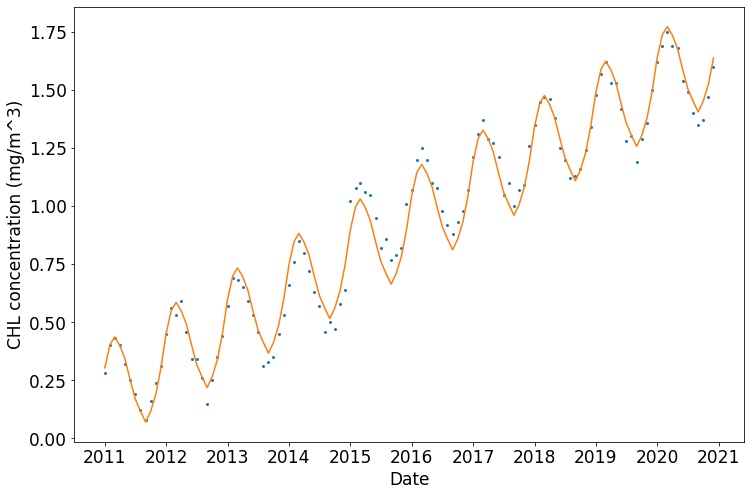

In [26]:
plt.clf()
fig = plt.figure(figsize=(12,8))
#
ax = plt.gca()
ax.plot(ps2_data.index, data['ch4'], 'o', ms=2)
# Fit
ax.plot(ps2_data.index, mod1.fittedvalues)
#
# 
ax.set_xlabel('Date')
ax.set_ylabel('CHL concentration (mg/m^3)')
set_fontsize(ax, 17)
#
plt.savefig('PS2_Q2_linear.png', dpi=300)
plt.show()

----

# Question 3 -- Residuals

In [24]:
resids_m1 = data.ch4 - mod1.fittedvalues

## Plot

<Figure size 432x288 with 0 Axes>

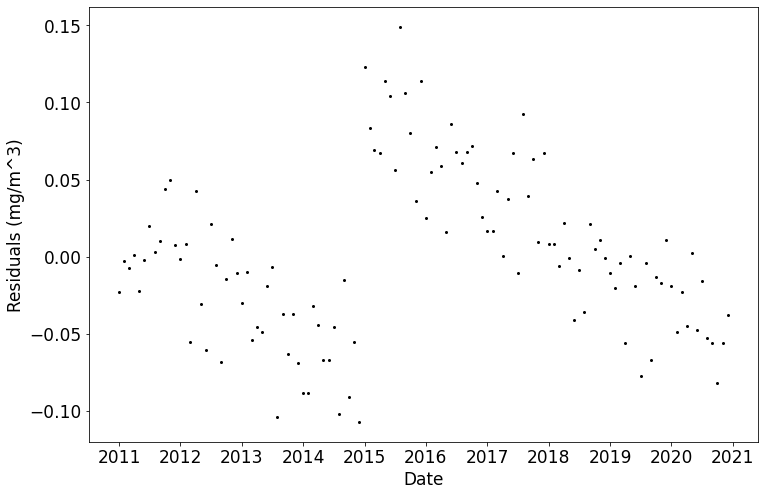

In [25]:
plt.clf()
fig = plt.figure(figsize=(12,8))
#
ax = plt.gca()
ax.plot(ps2_data.index, resids_m1, 'ko', ms=2)
#
# 
ax.set_xlabel('Date')
ax.set_ylabel('Residuals (mg/m^3)')
set_fontsize(ax, 17)
#
plt.savefig('PS2_Q3_resids.png', dpi=300)
plt.show()

----

# Question 4 -- Appropriate?

## Durbin

In [51]:
dw_m1 = durbin_watson(resids_m1[49:])
dw_m1

0.5700743714978939

## Shapiro

In [52]:
shapiro_m1 = shapiro(resids_m1)
shapiro_m1

ShapiroResult(statistic=0.9833453893661499, pvalue=0.14532946050167084)

## Far too much structure in the residuals.  Not appropriate

----

# Question 5 -- Intervention Dummy

In [34]:
dummyI = np.zeros(len(ps2_data))
new_data = np.where((ps2_data.year.values == 2015) & (ps2_data.month.values == 1))[0]
dummyI[new_data[0]:] = 1

In [35]:
data['dumI'] = dummyI

## New Fit

In [36]:
formula2 = "ch4 ~ dum0 + dum1 + dum2 + dum3 + dum4 + dum5 + dum6 + dum7 + dum8 + dum9 + dum10 + dumI + time"
mod2 = smf.glm(formula=formula2, data=data).fit()#, family=sm.families.Binomial()).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    ch4   No. Observations:                  120
Model:                            GLM   Df Residuals:                      106
Model Family:                Gaussian   Df Model:                           13
Link Function:               identity   Scale:                      0.00079982
Method:                          IRLS   Log-Likelihood:                 265.04
Date:                Mon, 18 Apr 2022   Deviance:                     0.084780
Time:                        06:02:44   Pearson chi2:                   0.0848
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1899      0.010     18.234      0.000       0.170       0.210
dum0           0.1130      0.013      8.862      0.000       0.088       0.138
dum1           0.2028      0.013     15.930      0.000       0.178       0.228
dum2           0.2266      0.013     17.824      0.000       0.202       0.252
dum3           0.1784      0.013     14.049      0.000       0.154       0.203
dum4           0.1112      0.013      8.768      0.000       0.086       0.136
dum5           0.0111      0.013      0.873      0.383      -0.014       0.036
dum6          -0.0811      0.013     -6.403      0.000      -0.106      -0.056
dum7          -0.1443      0.013    -11.397      0.000      -0.169      -0.119
dum8          -0.2015      0.013    -15.920      0.000      -0.226      -0.177
dum9          -0.1656      0.013    -13.094      0.000      -0.190      -0.141
dum10         -0.1018      0.013     -8.050      0.000      -0.127      -0.077
dumI           0.1806      0.010     17.897      0.000       0.161       0.200
time           0.0102      0.000     70.959      0.000       0.010       0.010
==============================================================================
"""

## Plot

<Figure size 432x288 with 0 Axes>

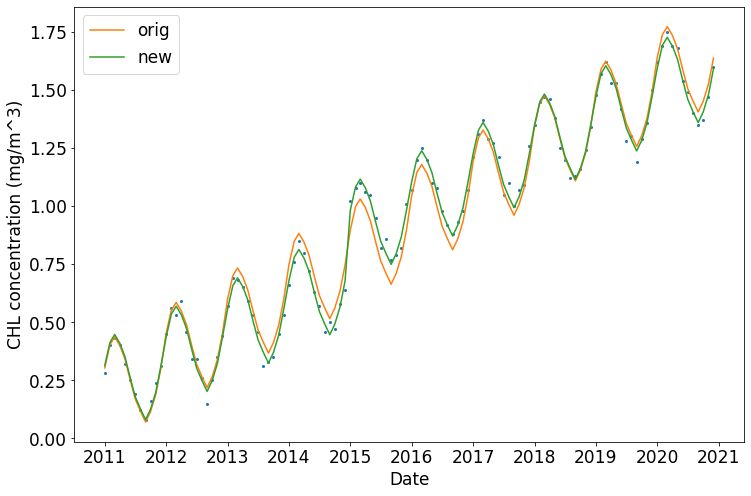

In [41]:
plt.clf()
fig = plt.figure(figsize=(12,8))
#
ax = plt.gca()
ax.plot(ps2_data.index, data['ch4'], 'o', ms=2)
# Fits
ax.plot(ps2_data.index, mod1.fittedvalues, label='orig')
ax.plot(ps2_data.index, mod2.fittedvalues, label='new')
#
# 
ax.set_xlabel('Date')
ax.set_ylabel('CHL concentration (mg/m^3)')
set_fontsize(ax, 17)
ax.legend(loc='upper left', fontsize=17)
#
plt.savefig('PS2_Q5_int.png', dpi=300)
plt.show()

----

# Question 6 -- Residuals

In [42]:
resids_m2 = data.ch4 - mod2.fittedvalues

<Figure size 432x288 with 0 Axes>

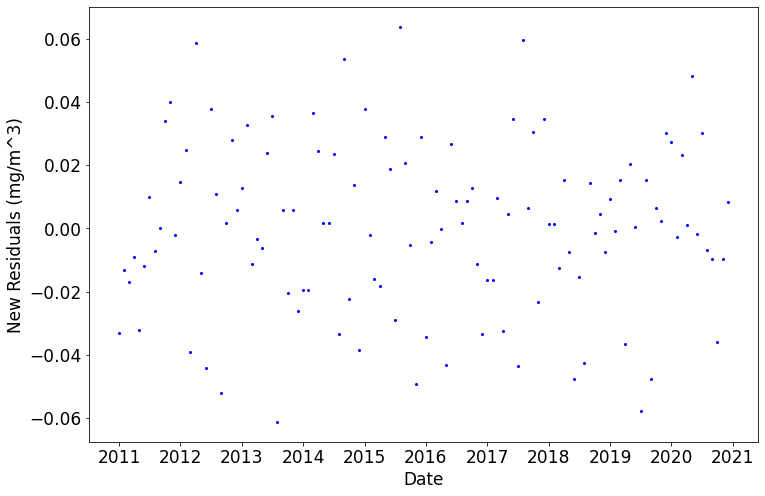

In [43]:
plt.clf()
fig = plt.figure(figsize=(12,8))
#
ax = plt.gca()
ax.plot(ps2_data.index, resids_m2, 'bo', ms=2)
#
# 
ax.set_xlabel('Date')
ax.set_ylabel('New Residuals (mg/m^3)')
set_fontsize(ax, 17)
#
plt.savefig('PS2_Q6_resids.png', dpi=300)
plt.show()

----

# Question 7 -- More appropriate?

## Durbin Watson

In [47]:
dw_m2 = durbin_watson(resids_m2)
dw_m2

2.4284820932447038

## Shapiro Wilk

In [46]:
shapiro(resids_m2)

ShapiroResult(statistic=0.9904218912124634, pvalue=0.5724934339523315)

## Yes, the residuals show limited structure and pass the standard residual tests

----

# Question 8

## See above

## Bartlett -- Splitting at January 2015

In [54]:
bartlett(resids_m2[:new_data[0]], resids_m2[new_data[0]:])

BartlettResult(statistic=0.22338383652408567, pvalue=0.6364736125939916)

----

In [55]:
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    ch4   No. Observations:                  120
Model:                            GLM   Df Residuals:                      106
Model Family:                Gaussian   Df Model:                           13
Link Function:               identity   Scale:                      0.00079982
Method:                          IRLS   Log-Likelihood:                 265.04
Date:                Mon, 18 Apr 2022   Deviance:                     0.084780
Time:                        06:19:46   Pearson chi2:                   0.0848
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1899      0.010     18.234      0.000       0.170       0.210
dum0           0.1130      0.013      8.862      0.000       0.088       0.138
dum1           0.2028      0.013     15.930      0.000       0.178       0.228
dum2           0.2266      0.013     17.824      0.000       0.202       0.252
dum3           0.1784      0.013     14.049      0.000       0.154       0.203
dum4           0.1112      0.013      8.768      0.000       0.086       0.136
dum5           0.0111      0.013      0.873      0.383      -0.014       0.036
dum6          -0.0811      0.013     -6.403      0.000      -0.106      -0.056
dum7          -0.1443      0.013    -11.397      0.000      -0.169      -0.119
dum8          -0.2015      0.013    -15.920      0.000      -0.226      -0.177
dum9          -0.1656      0.013    -13.094      0.000      -0.190      -0.141
dum10         -0.1018      0.013     -8.050      0.000      -0.127      -0.077
dumI           0.1806      0.010     17.897      0.000       0.161       0.200
time           0.0102      0.000     70.959      0.000       0.010       0.010
==============================================================================
"""

In [56]:
mod2.params

Intercept    0.189926
dum0         0.112952
dum1         0.202775
dum2         0.226597
dum3         0.178420
dum4         0.111242
dum5         0.011065
dum6        -0.081113
dum7        -0.144290
dum8        -0.201468
dum9        -0.165645
dum10       -0.101823
dumI         0.180602
time         0.010177
dtype: float64

In [65]:
cov = mod2.cov_params()

2.0571391160747056e-08

In [68]:
np.sqrt(cov.time.time)

0.00014342730270331048

In [67]:
np.sqrt(cov.dumI.dumI)

0.01009100521482856

## Trend = 0.010 mg per m^3 per month with an error of 1e-4, i.e. highly significant

## Intervention effect = 0.18 mg per m^3 with an error of 0.01, i.e. also highly significant